<a href="https://colab.research.google.com/github/novoforce/Exploring-Tensorflow/blob/main/multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the dataset

In [1]:
mkdir dataset

In [2]:
cd dataset

/content/dataset


In [3]:
! curl -L "https://app.roboflow.com/ds/EYWP025nf4?key=bOv6xVqzBY" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0    814      0  0:00:01  0:00:01 --:--:--   814
100  213M  100  213M    0     0  50.1M      0  0:00:04  0:00:04 --:--:-- 72.1M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
   creating: test/black_jeans/
 extracting: test/black_jeans/00000018_jpg.rf.4b4c71f74f61993513be7311a618396f.jpg  
 extracting: test/black_jeans/00000021_jpg.rf.3908dd338a0e69598462582c44853d24.jpg  
 extracting: test/black_jeans/00000028_jpg.rf.00cbda5ac28a1f91a59b02dea79259d9.jpg  
 extracting: test/black_jeans/00000046_jpeg.rf.1bdb2329204fae0d96d115dcb43bfee4.jpg  
 extracting: test/black_jeans/00000060_jpg.rf.bb9816dc6de2d8978161bd6b6f4dcd53.jpg  
 extracting: test/black_jeans/00000068_jpg.rf.871d13e54ac6b657e27d286e1242fbd2.jpg  
 extracting: test/black_

In [4]:
cd ..

/content


# Importing Libraries

In [31]:
tf.compat.v1.disable_eager_execution()

In [63]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import img_to_array,ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from imutils import paths,resize
import numpy as np
import random
import pickle
import os
import cv2

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Activation,Flatten,Dropout,Dense
from keras import backend as K

# Dataset pre-processing

In [33]:
IMG_DIMS= (96,96,3) # The dimensions on which model has to be built

In [136]:
DATASET_PATH= '/content/dataset'

imagePaths = sorted(list(paths.list_images(DATASET_PATH)))
print("Image path list:> ",imagePaths)
random.seed(42)
random.shuffle(imagePaths)

#initialize data and labels list 
data = []
labels = []

for imagepath in imagePaths:
    image= cv2.imread(imagepath)
    image= cv2.resize(image,(IMG_DIMS[1],IMG_DIMS[0])) # width,height
    image = img_to_array(image)
    data.append(image)

    #extract the labels from the "folder names"
    l = imagepath.split("/")[-2].split("_")
    labels.append(l)

# convert the data and the labels to an array
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)


print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))
print(labels)



Image path list:>  ['/content/dataset/test/black_jeans/00000018_jpg.rf.4b4c71f74f61993513be7311a618396f.jpg', '/content/dataset/test/black_jeans/00000021_jpg.rf.3908dd338a0e69598462582c44853d24.jpg', '/content/dataset/test/black_jeans/00000028_jpg.rf.00cbda5ac28a1f91a59b02dea79259d9.jpg', '/content/dataset/test/black_jeans/00000046_jpeg.rf.1bdb2329204fae0d96d115dcb43bfee4.jpg', '/content/dataset/test/black_jeans/00000060_jpg.rf.bb9816dc6de2d8978161bd6b6f4dcd53.jpg', '/content/dataset/test/black_jeans/00000068_jpg.rf.871d13e54ac6b657e27d286e1242fbd2.jpg', '/content/dataset/test/black_jeans/00000070_jpeg.rf.af26eac3ece26fd89304e2d637ccab99.jpg', '/content/dataset/test/black_jeans/00000071_jpg.rf.7a5df2cb7d707876e5cd95d5af08e89d.jpg', '/content/dataset/test/black_jeans/00000082_jpg.rf.0fb1228d0d1d13d1a0f9e7c1ddbdf12a.jpg', '/content/dataset/test/black_jeans/00000116_jpeg.rf.8b379b28551949a73fec03b65b359e90.jpg', '/content/dataset/test/black_jeans/00000127_jpeg.rf.c576586d95d2b9af4c3b5086f

In [137]:
print("[INFO] class labels:")
mlb = MultiLabelBinarizer() #binarize the labels ---> encoding
labels_encoded = mlb.fit_transform(labels)

for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))
 
# first 9 encoded labels
for i in range(0,9):
    print(labels_encoded[i])

[INFO] class labels:
1. black
2. blue
3. dress
4. jeans
5. red
6. shirt
[0 1 1 0 0 0]
[0 0 0 0 1 1]
[0 1 0 1 0 0]
[1 0 0 1 0 0]
[0 0 1 0 1 0]
[0 1 0 1 0 0]
[0 1 1 0 0 0]
[0 0 1 0 1 0]
[1 0 0 1 0 0]


# Visualize the dataset

In [138]:
#<----------------------------------------------FOR CODE TESTING------------------------------------>
# classes= {0: 'black', 1: 'blue', 2: 'dress', 3: 'jeans', 4: 'red', 5: 'shirt'}
# tests= [1,2]

# for test_i in tests:
#     if test_i in classes:
#         print(classes[test_i])

# qwert= [classes[test_i] for test_i in tests if test_i in classes]
# print(qwert)


# plt.imshow(data[0])
# b,g,r = cv2.split(data[0])
# rgb_img = cv2.merge([r,g,b])  
# plt.imshow(rgb_img) 

# data1 = data[0][:]
# plt.imshow(data1)
# data1[:,:,0], data1[:,:,2] =  data1[:,:,2], data1[:,:,0]
# plt.imshow(data1)

# B G R --> R G B 
# plt.imshow(data[0])
# print(data[0].shape)
# data[0][:,:,]

Classes available:>  {0: 'black', 1: 'blue', 2: 'dress', 3: 'jeans', 4: 'red', 5: 'shirt'}


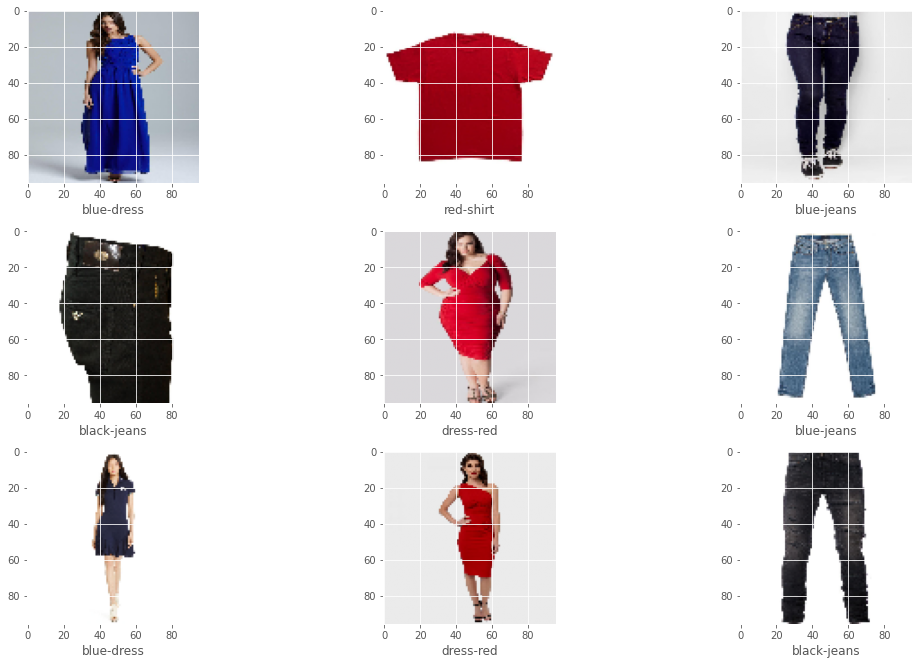

In [139]:
# CLASSES= {}
CLASSES= {}
for i,labels in enumerate(mlb.classes_):
    CLASSES[i] = labels
print("Classes available:> ",CLASSES)
plt.figure(figsize=(15, 15))
for i in range(0,9):
    plt.subplot(5, 3, i+1)
    b,g,r = cv2.split(data[i]) #splitting the image to (B G R) as the image was read in openCV
    data_rgb= cv2.merge([r,g,b]) # merge back the image array to R G B channels
    plt.imshow(data_rgb) #'image_list' is the list of images
    label_list= np.argsort(labels_encoded[i])[::-1][:2] #top 2 labels with 1
    label_twin= [CLASSES[labels] for labels in label_list if labels in CLASSES] #convert number encoding to labels
    plt.xlabel(label_twin[1]+"-"+label_twin[0]) # 'labels' is the list of labels
plt.tight_layout()
plt.show()

In [36]:
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)

#Augmentations to be applied
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

# Model building

In [37]:
# import the necessary packages

class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

		# CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

	    # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
       
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation(finalAct))
        
        # plot the model architecture in shell
        model.summary()
		# return the constructed network architecture
        return model

class SimpleNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

		# CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

	    # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # use global average pooling instead of fc layer
        model.add(GlobalAveragePooling2D())
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
       
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation(finalAct))
        
        # plot the model architecture in shell
        model.summary()
		# return the constructed network architecture
        return model


In [38]:
# model = SmallerVGGNet.build(
# 	width=IMG_DIMS[1], height=IMG_DIMS[0],
# 	depth=IMG_DIMS[2], classes=len(mlb.classes_),
# 	finalAct="sigmoid") #sigmoid will be used for Multi-label classification

model = SimpleNet.build(
	width=IMG_DIMS[1], height=IMG_DIMS[0],
	depth=IMG_DIMS[2], classes=len(mlb.classes_),
	finalAct="sigmoid") #sigmoid will be used for Multi-label classification

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
activation_23 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
________________________________________________

In [39]:
INIT_LR = 1e-3
EPOCHS = 75
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
BS = 32

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

History = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

Epoch 1/75
51/51 [==============================] - ETA: 0s - batch: 25.0000 - size: 31.9216 - loss: 0.3864 - accuracy: 0.8455

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


51/51 [==============================] - 9s 106ms/step - batch: 25.0000 - size: 31.9216 - loss: 0.3864 - accuracy: 0.8455 - val_loss: 1.0040 - val_accuracy: 0.6218
Epoch 2/75
51/51 [==============================] - 6s 115ms/step - batch: 25.0000 - size: 31.9216 - loss: 0.2435 - accuracy: 0.9089 - val_loss: 0.9717 - val_accuracy: 0.6194
Epoch 3/75
51/51 [==============================] - 6s 112ms/step - batch: 25.0000 - size: 31.9216 - loss: 0.1989 - accuracy: 0.9287 - val_loss: 1.3302 - val_accuracy: 0.6214
Epoch 4/75
51/51 [==============================] - 6s 112ms/step - batch: 25.0000 - size: 31.9216 - loss: 0.1618 - accuracy: 0.9391 - val_loss: 1.2516 - val_accuracy: 0.6350
Epoch 5/75
51/51 [==============================] - 6s 113ms/step - batch: 25.0000 - size: 31.9216 - loss: 0.1570 - accuracy: 0.9470 - val_loss: 0.8065 - val_accuracy: 0.7548
Epoch 6/75
51/51 [==============================] - 6s 114ms/step - batch: 25.0000 - size: 31.9216 - loss: 0.1403 - accuracy: 0.9506 - v

# Plotting metrics

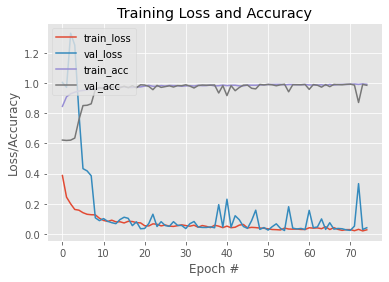

In [40]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

# Inference

In [ ]:
! curl https://raw.githubusercontent.com/ItchyHiker/Multi_Label_Classification_Keras/master/examples/example_01.jpg > example_01.jpg
! curl https://raw.githubusercontent.com/ItchyHiker/Multi_Label_Classification_Keras/master/examples/example_02.jpg > example_02.jpg
! curl https://raw.githubusercontent.com/ItchyHiker/Multi_Label_Classification_Keras/master/examples/example_03.jpg > example_03.jpg
! curl https://raw.githubusercontent.com/ItchyHiker/Multi_Label_Classification_Keras/master/examples/example_04.jpg > example_04.jpg
! curl https://raw.githubusercontent.com/ItchyHiker/Multi_Label_Classification_Keras/master/examples/example_05.jpg > example_05.jpg
! curl https://raw.githubusercontent.com/ItchyHiker/Multi_Label_Classification_Keras/master/examples/example_06.jpg > example_06.jpg
! curl https://raw.githubusercontent.com/ItchyHiker/Multi_Label_Classification_Keras/master/examples/example_07.jpg > example_07.jpg


In [64]:
image= cv2.imread("example_01.jpg")
output = resize(image, width=400)
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0 #normalize
image = img_to_array(image) #
image = np.expand_dims(image, axis=0)

proba = model.predict(image)[0]
idxs = np.argsort(proba)[::-1][:2]
print(proba, idxs)

[7.6473865e-05 2.3821267e-06 9.9951601e-01 4.0902691e-05 1.0000000e+00
 1.2813995e-03] [4 2]


In [66]:
for (i, j) in enumerate(idxs):
	# build the label and draw the label on the image
	label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
	cv2.putText(output, label, (10, (i * 30) + 25), 
		cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
 
 # show the probabilities for each of the individual labels
for (label, p) in zip(mlb.classes_, proba):
	print("{}: {:.2f}%".format(label, p * 100))

black: 0.01%
blue: 0.00%
dress: 99.95%
jeans: 0.00%
red: 100.00%
shirt: 0.13%


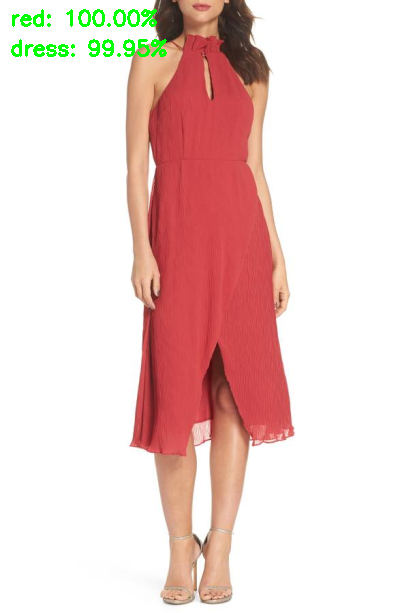

In [69]:
from google.colab.patches import cv2_imshow
cv2_imshow(output)

# Personal testing space-->

In [70]:
image= cv2.imread("example_01.jpg")
output = resize(image, width=400)
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0 #normalize
image = img_to_array(image) #
print("shape of the image array:> ",image.shape) #(96,96,3)
image = np.expand_dims(image, axis=0)
print("shape of the image array after expanding:> ",image.shape) #(1,96,96,3)

shape of the image array:>  (96, 96, 3)
shape of the image array after expanding:>  (1, 96, 96, 3)


In [77]:
proba = model.predict(image)
print("probabilities scores :> ",proba,proba.shape) #6 probabilities for each classes is printed
proba= proba[0]
print("probabilities scores :> ",proba)
idxs= np.argsort(proba)
print("probabilities scores indexes(ascending) :> ",idxs)
idxs= np.argsort(proba)[::-1]
print("probabilities scores indexes(descending) :> ",idxs)
idxs= np.argsort(proba)[::-1][:2] # AS 2 LABELS(PREDICTION) ARE THERE FOR EACH IMAGE
print("top 2 probabilities scores indexes(descending) :> ",idxs)

probabilities scores :>  [[7.6473865e-05 2.3821267e-06 9.9951601e-01 4.0902691e-05 1.0000000e+00
  1.2813995e-03]] (1, 6)
probabilities scores :>  [7.6473865e-05 2.3821267e-06 9.9951601e-01 4.0902691e-05 1.0000000e+00
 1.2813995e-03]
probabilities scores indexes(ascending) :>  [1 3 0 5 2 4]
probabilities scores indexes(descending) :>  [4 2 5 0 3 1]
top 2 probabilities scores indexes(descending) :>  [4 2]
